### Benchmarking (on M1 Pro, 8-core CPU, 14-core GPU):

In [1]:
import torch
device = torch.device('cpu')
x = torch.rand((10000,10000), dtype=torch.float32)
y = torch.rand((10000,10000), dtype=torch.float32)
x = x.to(device)
y = y.to(device)

In [2]:
%%timeit
x * y

13.8 ms ± 734 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [3]:
import torch
device = torch.device('mps')
x = torch.rand((10000,10000), dtype=torch.float32)
y = torch.rand((10000,10000), dtype=torch.float32)
x = x.to(device)
y = y.to(device)

In [4]:
%%timeit
x * y

6.94 ms ± 141 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Debug idf

In [5]:
from __future__ import print_function
import argparse
import time
import torch
import torch.utils.data
import torch.optim as optim
import numpy as np
import math
import random

import os

import datetime

from optimization.training import train, evaluate
from utils.load_data import load_dataset

In [6]:
parser = argparse.ArgumentParser(description='PyTorch Discrete Normalizing flows')

parser.add_argument('-d', '--dataset', type=str, default='tiny-imagenet-200',
                    choices=['cifar10', 'imagenet32', 'imagenet64', 'tiny-imagenet-200'],
                    metavar='DATASET',
                    help='Dataset choice.')

parser.add_argument('-nc', '--no_cuda', action='store_true', default=False,
                    help='disables CUDA training')

parser.add_argument('--manual_seed', type=int, help='manual seed, if not given resorts to random seed.')

parser.add_argument('-li', '--log_interval', type=int, default=20, metavar='LOG_INTERVAL',
                    help='how many batches to wait before logging training status')

parser.add_argument('--evaluate_interval_epochs', type=int, default=25,
                    help='Evaluate per how many epochs')

parser.add_argument('-od', '--out_dir', type=str, default='snapshots', metavar='OUT_DIR',
                    help='output directory for model snapshots etc.')

fp = parser.add_mutually_exclusive_group(required=False)
fp.add_argument('-te', '--testing', action='store_true', dest='testing',
                help='evaluate on test set after training')
fp.add_argument('-va', '--validation', action='store_false', dest='testing',
                help='only evaluate on validation set')
parser.set_defaults(testing=True)

# optimization settings
parser.add_argument('-e', '--epochs', type=int, default=2000, metavar='EPOCHS',
                    help='number of epochs to train (default: 2000)')
parser.add_argument('-es', '--early_stopping_epochs', type=int, default=300, metavar='EARLY_STOPPING',
                    help='number of early stopping epochs')

parser.add_argument('-bs', '--batch_size', type=int, default=256, metavar='BATCH_SIZE',
                    help='input batch size for training (default: 100)')
parser.add_argument('-lr', '--learning_rate', type=float, default=0.001, metavar='LEARNING_RATE',
                    help='learning rate')
parser.add_argument('--warmup', type=int, default=10,
                    help='number of warmup epochs')

parser.add_argument('--data_augmentation_level', type=int, default=2,
                    help='data augmentation level')

parser.add_argument('--variable_type', type=str, default='discrete',
                    help='variable type of data distribution: discrete/continuous',
                    choices=['discrete', 'continuous'])
parser.add_argument('--distribution_type', type=str, default='logistic',
                    choices=['logistic', 'normal', 'steplogistic'],
                    help='distribution type: logistic/normal')
parser.add_argument('--n_flows', type=int, default=8,
                    help='number of flows per level')
parser.add_argument('--n_levels', type=int, default=3,
                    help='number of levels')

parser.add_argument('--n_bits', type=int, default=8,
                    help='')

# ---------------- SETTINGS CONCERNING NETWORKS -------------
parser.add_argument('--densenet_depth', type=int, default=8,
                    help='Depth of densenets')
parser.add_argument('--n_channels', type=int, default=512,
                    help='number of channels in coupling and splitprior')
# ---------------- ----------------------------- -------------


# ---------------- SETTINGS CONCERNING COUPLING LAYERS -------------
parser.add_argument('--coupling_type', type=str, default='densenet',
                    choices=['shallow', 'resnet', 'densenet'],
                    help='Type of coupling layer')
parser.add_argument('--splitfactor', default=0, type=int,
                    help='Split factor for coupling layers.')

parser.add_argument('--split_quarter', dest='split_quarter', action='store_true',
                    help='Split coupling layer on quarter')
parser.add_argument('--no_split_quarter', dest='split_quarter', action='store_false')
parser.set_defaults(split_quarter=True)
# ---------------- ----------------------------------- -------------


# ---------------- SETTINGS CONCERNING SPLITPRIORS -------------
parser.add_argument('--splitprior_type', type=str, default='densenet',
                    choices=['none', 'shallow', 'resnet', 'densenet'],
                    help='Type of splitprior. Use \'none\' for no splitprior')
# ---------------- ------------------------------- -------------


# ---------------- SETTINGS CONCERNING PRIORS -------------
parser.add_argument('--n_mixtures', type=int, default=1,
                    help='number of mixtures')
# ---------------- ------------------------------- -------------

parser.add_argument('--hard_round', dest='hard_round', action='store_true',
                    help='Rounding of translation in discrete models. Weird '
                    'probabilistic implications, only for experimental phase')
parser.add_argument('--no_hard_round', dest='hard_round', action='store_false')
parser.set_defaults(hard_round=True)

parser.add_argument('--round_approx', type=str, default='smooth',
                    choices=['smooth', 'stochastic'])

parser.add_argument('--lr_decay', default=0.999, type=float,
                    help='Learning rate')

parser.add_argument('--temperature', default=1.0, type=float,
                    help='Temperature used for BackRound. It is used in '
                    'the the SmoothRound module. '
                    '(default=1.0')

# gpu/cpu
parser.add_argument('--gpu_num', type=int, default=0, metavar='GPU',
                    help='choose GPU to run on.')

args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
args.mps = not args.cuda and torch.backends.mps.is_available()

if args.manual_seed is None:
    args.manual_seed = random.randint(1, 100000)
random.seed(args.manual_seed)
torch.manual_seed(args.manual_seed)
np.random.seed(args.manual_seed)


kwargs = {'num_workers': 4, 'pin_memory': True} if args.cuda else {'num_workers': 4, 'pin_memory': False} if args.mps else {}

print('\nMODEL SETTINGS: \n', args, '\n')
print("Random Seed: ", args.manual_seed)
if 'imagenet' in args.dataset and args.evaluate_interval_epochs > 5:
        args.evaluate_interval_epochs = 5


MODEL SETTINGS: 
 Namespace(dataset='tiny-imagenet-200', no_cuda=False, manual_seed=7117, log_interval=20, evaluate_interval_epochs=25, out_dir='snapshots', testing=True, epochs=2000, early_stopping_epochs=300, batch_size=256, learning_rate=0.001, warmup=10, data_augmentation_level=2, variable_type='discrete', distribution_type='logistic', n_flows=8, n_levels=3, n_bits=8, densenet_depth=8, n_channels=512, coupling_type='densenet', splitfactor=0, split_quarter=True, splitprior_type='densenet', n_mixtures=1, hard_round=True, round_approx='smooth', lr_decay=0.999, temperature=1.0, gpu_num=0, cuda=False, mps=True) 

Random Seed:  7117


### Load data

In [7]:
train_loader, val_loader, test_loader, args = load_dataset(args, **kwargs)

Starting loading ImageNet
Number of data images 100000
Number of val images: 10000
Number of test images: 10000


### Visualizing ImageNet Data

In [15]:
dataiter = iter(val_loader)

/Users/haohan/Documents/information-theory/idf/utils/load_data.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1656352706847/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(np.array(X_i, copy=False)).permute(2, 0, 1)
/Users/haohan/Documents/information-theory/idf/utils/load_data.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be 

In [16]:
import torchvision
import matplotlib.pyplot as plt
images, labels = dataiter.next()
images = images[:8]

In [17]:
print(images.size())

torch.Size([8, 3, 64, 64])


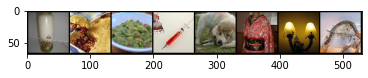

Labels:tensor(0) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0) tensor(0)
torch.Size([8, 3, 64, 64])
torch.Size([8, 12288])


In [18]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ' '.join('%9s' % labels[j] for j in range(8)))

flat = torch.flatten(images, 1)
print(images.size())
print(flat.size())

### Select model (flow parameters and architecture choice are passed on to model through args)

In [12]:
print(args.input_size)

import models.Model as Model

model = Model.Model(args)
args.device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")
model.set_temperature(args.temperature)
model.enable_hard_round(args.hard_round)

model_sample = model

# data dependend initialization on CPU
for batch_idx, (data, _) in enumerate(train_loader):
    model(data)
    break

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = torch.nn.DataParallel(model, dim=0)

model.to(args.device)

def lr_lambda(epoch):
    return min(1., (epoch+1) / args.warmup) * np.power(args.lr_decay, epoch)
optimizer = optim.Adamax(model.parameters(), lr=args.learning_rate, eps=1.e-7)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda, last_epoch=-1)

[3, 64, 64]


/Users/haohan/Documents/information-theory/idf/utils/load_data.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1656352706847/work/torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(np.array(X_i, copy=False)).permute(2, 0, 1)
/Users/haohan/Documents/information-theory/idf/utils/load_data.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be 

### Train Model

In [13]:
train_bpd = []
val_bpd = []

# for early stopping
best_val_bpd = np.inf
best_train_bpd = np.inf
epoch = 0

train_times = []

model.eval()
model.train()

Model(
  (normalize): Normalize()
  (flow): GenerativeFlow(
    (layers): ModuleList(
      (0): Squeeze()
      (1): Permute()
      (2): Coupling(
        (coupling): SplitFactorCoupling(
          (round): BackRound(
            (round): SmoothRound()
          )
          (nn): NN(
            (nn): Sequential(
              (0): DenseBlock(
                (nn): Sequential(
                  (0): DenseLayer(
                    (nn): Sequential(
                      (0): Conv2dReLU(
                        (nn): Conv2d(9, 9, kernel_size=(1, 1), stride=(1, 1))
                      )
                      (1): Conv2dReLU(
                        (nn): Conv2d(9, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                      )
                    )
                  )
                  (1): DenseLayer(
                    (nn): Sequential(
                      (0): Conv2dReLU(
                        (nn): Conv2d(73, 73, kernel_size=(1, 1), stride=(1, 1))
            

In [14]:
args.epochs

2000

In [9]:
from torch.nn import Parameter
import torch

In [10]:
mu = Parameter(torch.Tensor(2, 3, 4))

In [12]:
mu.repeat(1,1,1).shape

torch.Size([2, 3, 4])